# Round 3: Trade baskets

In [3]:
from Utils.Config import DATA_DIR
from Utils.Config import CHARTS_DIR
from Utils import dataUtils
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
files_1 = dataUtils.getDataPaths(1)
files_2 = dataUtils.getDataPaths(2)
files_3 = dataUtils.getDataPaths(3)
files = files_1 + files_2 + files_3
dfs = dataUtils.concat_dfs("prices",files)
dfs

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,ask_volume_3,mid_price,profit_and_loss,ORCHIDS,TRANSPORT_FEES,EXPORT_TARIFF,IMPORT_TARIFF,SUNLIGHT,HUMIDITY,DAY
0,-1.0,0,AMETHYSTS,10002.0,1.0,9996.0,2.0,9995.0,29.0,10004.0,...,NaN,10003.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.0,0,STARFRUIT,5045.0,1.0,5040.0,31.0,NaN,NaN,5047.0,...,NaN,5046.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1.0,100,STARFRUIT,5040.0,24.0,NaN,NaN,NaN,NaN,5046.0,...,NaN,5043.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1.0,100,AMETHYSTS,9996.0,2.0,9995.0,22.0,NaN,NaN,10004.0,...,NaN,10000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-1.0,200,AMETHYSTS,9995.0,20.0,NaN,NaN,NaN,NaN,10005.0,...,NaN,10000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209998,2.0,999800,GIFT_BASKET,69537.0,2.0,69536.0,18.0,69535.0,24.0,69547.0,...,24.0,69542.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
209999,2.0,999900,CHOCOLATE,7749.0,143.0,NaN,NaN,NaN,NaN,7751.0,...,NaN,7750.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
210000,2.0,999900,GIFT_BASKET,69551.0,1.0,69550.0,19.0,69549.0,20.0,69561.0,...,20.0,69556.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
210001,2.0,999900,STRAWBERRIES,3984.0,240.0,NaN,NaN,NaN,NaN,3985.0,...,NaN,3984.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Portfolio Optimization

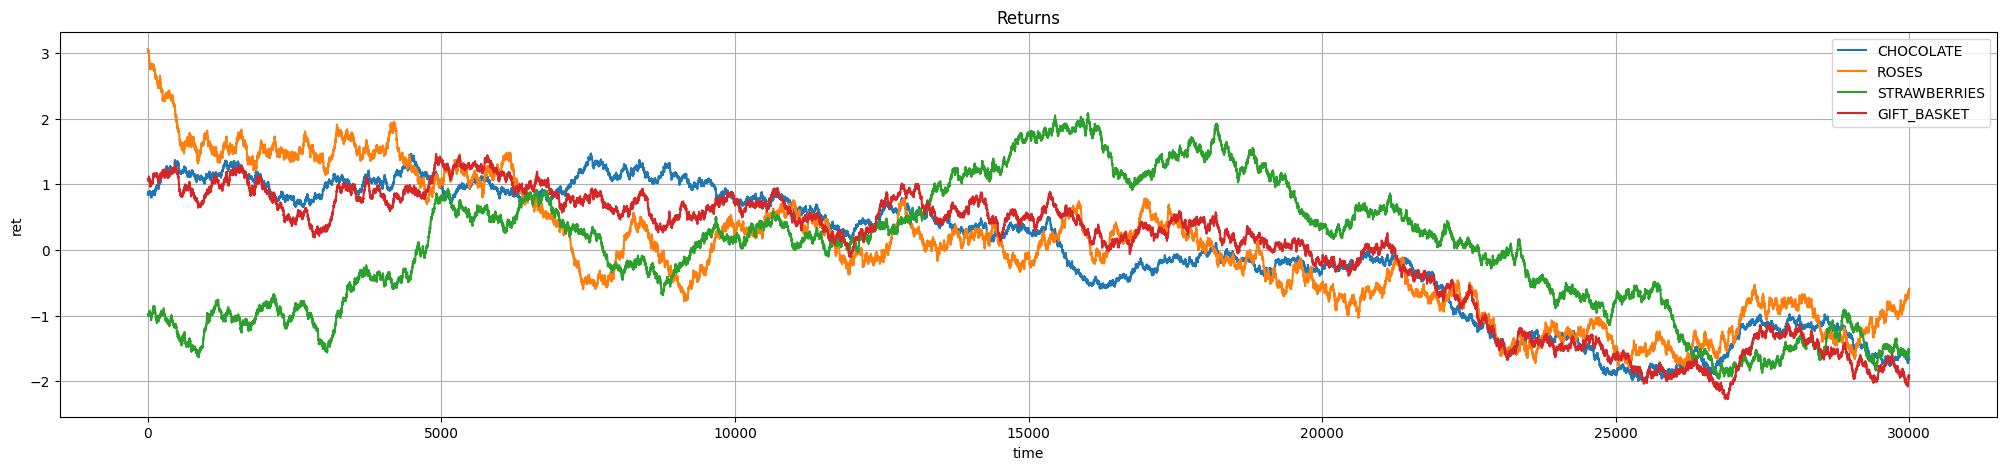

In [19]:
products = ["CHOCOLATE", "ROSES", "STRAWBERRIES", "GIFT_BASKET"]
portfolio_opt = {}
for i in products:
    portfolio_opt[i] = dfs[dfs["product"] == i].mid_price.values

returns_df = pd.DataFrame(portfolio_opt)
df_normalized = (returns_df - returns_df.mean()) / returns_df.std()
x = df_normalized.index
plt.figure(figsize=(25, 5))
for col in df_normalized.columns:
    plt.plot(x, df_normalized[col], label=col)

plt.xlabel('time')
plt.ylabel('ret')
plt.title('Returns')
plt.legend()
plt.grid(True)

> Observations:
- 1. Strawberries are not very liquid -> we can take savgol filter and trade volatility
- 2. Chocolate and GiftBasket are very cointegrated and can me used to pair trade


## Pairs Trading

<Axes: >

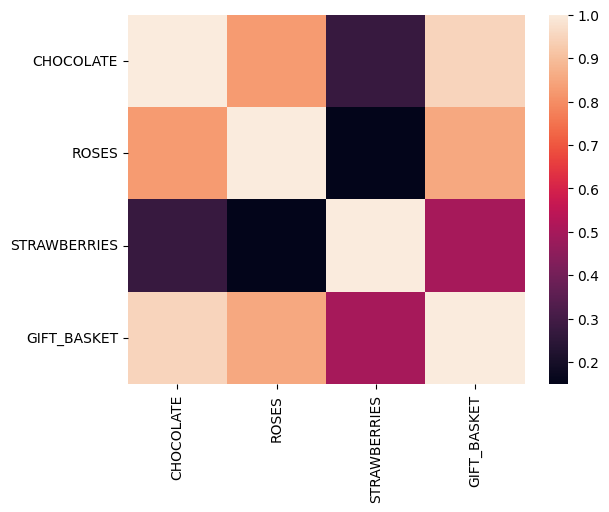

In [37]:
corr = df_normalized.corr()
sns.heatmap(corr)

> Chocolate is very correlated with the gift basket or benchmark. Chocolate vs roses are a pair that can be traded

## Cointegration

#### 1. Calculate spread between chocolate and gift 

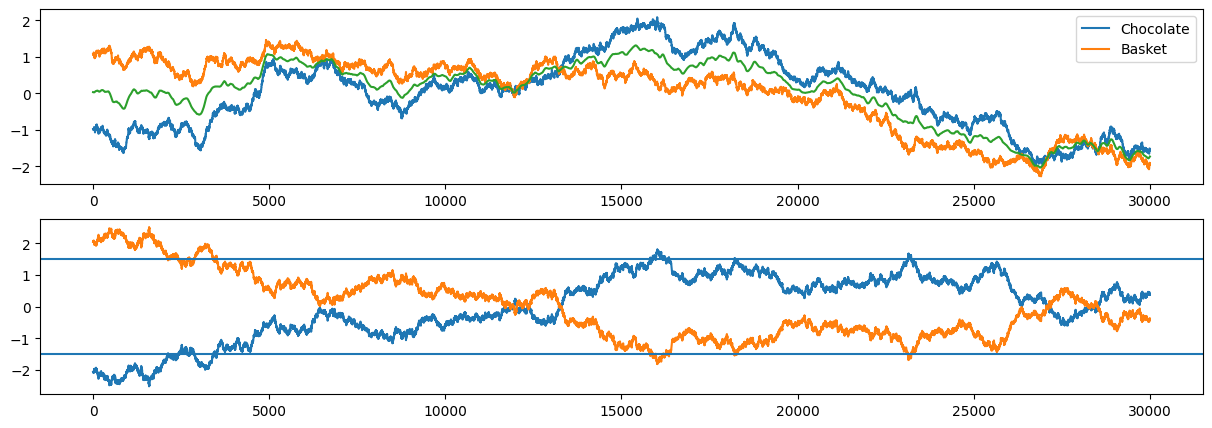

In [41]:
import scipy.stats as stats
from Utils.dataUtils import savitzky_golay

midpoint = (df_normalized["GIFT_BASKET"] + df_normalized["STRAWBERRIES"])/2
choco_spread = stats.zscore(df_normalized["GIFT_BASKET"]- midpoint)
basket_spread = stats.zscore(df_normalized["STRAWBERRIES"]- midpoint)
mean_rev_value = savitzky_golay(midpoint.values, window_size=101, order=1)
fig, axs = plt.subplots(2,1, figsize=(15,5))

axs[0].plot(df_normalized["STRAWBERRIES"])
axs[0].plot(df_normalized["GIFT_BASKET"])
axs[0].plot(mean_rev_value)
axs[0].legend(labels=["Chocolate", "Basket"])
axs[1].plot(basket_spread)
axs[1].plot(choco_spread)
axs[1].axhline(-1.5)
axs[1].axhline(1.5)


> There seems to be a possible strategy between this two assets. Next we are calculating the cointegration 

In [39]:
from statsmodels.tsa.stattools import coint

cointegration_gift_choco = coint(df_normalized["GIFT_BASKET"], df_normalized["STRAWBERRIES"])
cointegration_roses_choco = coint(df_normalized["GIFT_BASKET"], df_normalized["CHOCOLATE"])
print("Cointegration CHOC vs GIFT : ", cointegration_gift_choco[1])
print("Cointegration ROSE vs GIFT : ", cointegration_roses_choco[1])

Cointegration CHOC vs GIFT :  0.741445221127164
Cointegration ROSE vs GIFT :  0.07173437568773933


#### Process Strawberry and EDA Of SAVGOL params

In [ ]:
from dataUtils import savitzky_golay

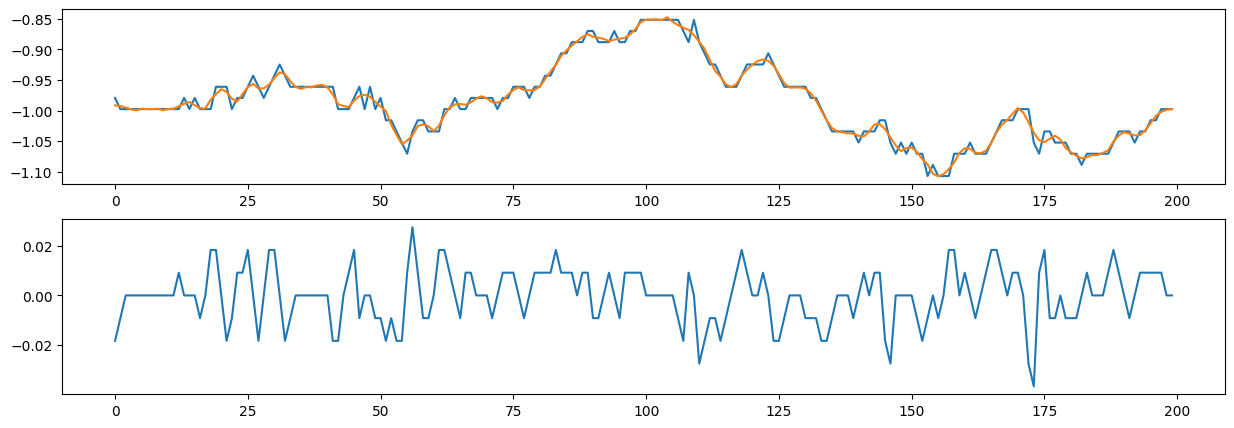

In [11]:
signal = df_normalized.STRAWBERRIES[:200]
savgol = savitzky_golay(signal.values, window_size=11, order=5)
gradient = np.gradient(signal)

fig, axs = plt.subplots(2,1, figsize=(15,5))
x = signal.index
axs[0].plot(x,signal)
axs[0].plot(x,savgol)
axs[1].plot(x,gradient)

In [50]:
A = dfs[dfs["product"] == "AMETHYSTS"].mid_price.values
S = dfs[dfs["product"] == "STARFRUIT"].mid_price.values
C = dfs[dfs["product"] == "CHOCOLATE"].mid_price.values
R = dfs[dfs["product"] == "ROSES"].mid_price.values
Sw = dfs[dfs["product"] == "STRAWBERRIES"].mid_price.values
G = dfs[dfs["product"] == "GIFT_BASKET"].mid_price.values
products = ["STARFRUIT", "GIFT_BASKET", "CHOCOLATE", "STRAWBERRIES", "ROSES"]

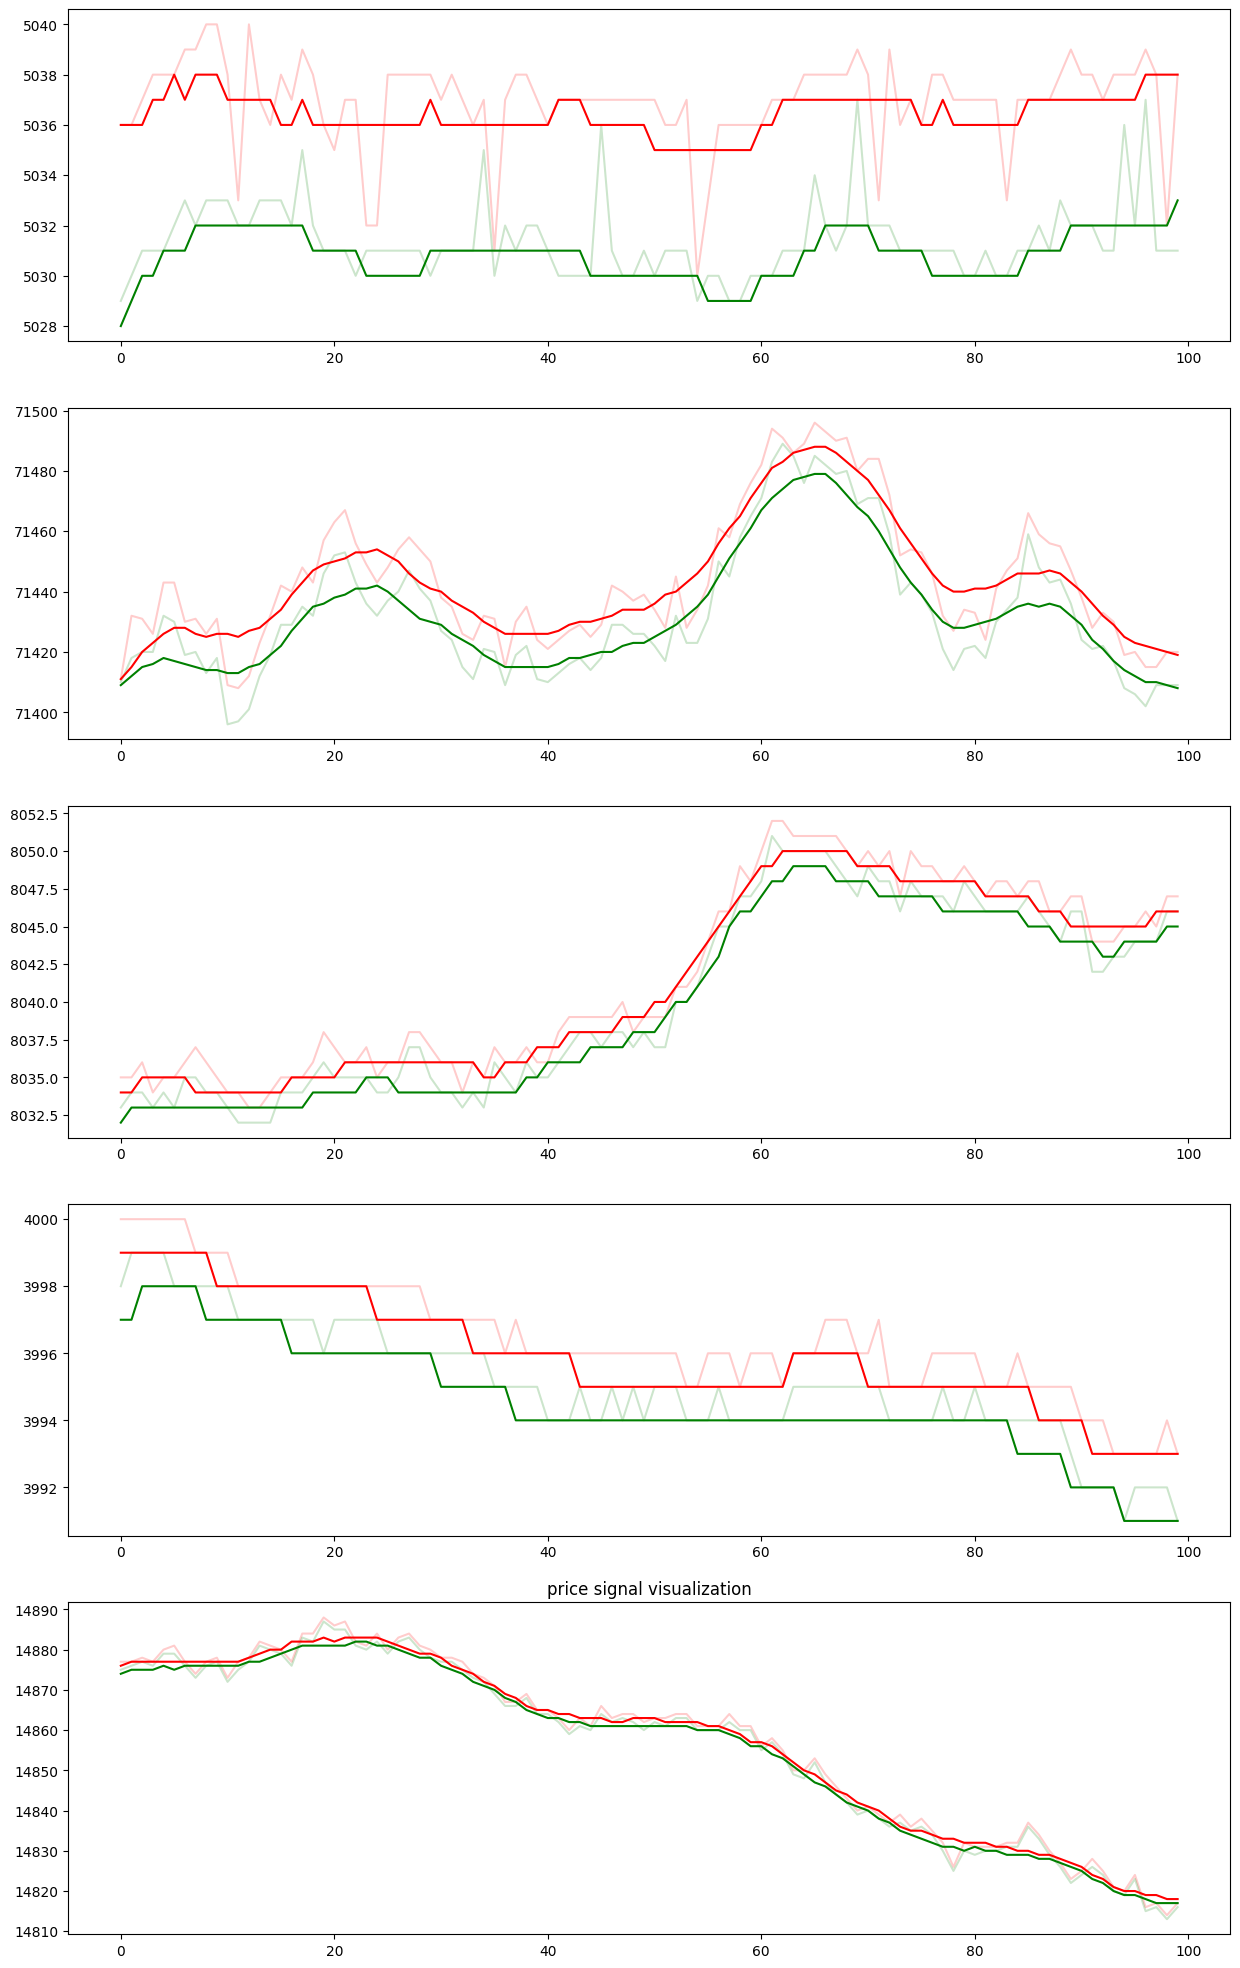

In [54]:
fig, axs = plt.subplots(len(products),1, figsize=(15,25))
plt.title("price signal visualization")
l, h = 400,500
for i, prod in enumerate(products):
    mid_price = dfs[dfs["product"] == prod].mid_price.values[l:h]
    deviation = np.var(mid_price)
    x = np.arange(len(mid_price))
    savgol_pred = np.int32(savitzky_golay(mid_price, window_size=11, order=1))
    gradient = np.gradient(savgol_pred)

    ask = dfs[dfs["product"]==prod].ask_price_1.values[l:h]
    bid = dfs[dfs["product"]==prod].bid_price_1.values[l:h]
    sav_ask, sav_bid =  np.int32(savitzky_golay(ask, window_size=11, order=1)),  np.int32(savitzky_golay(bid, window_size=11, order=1))

    axs[i].plot(ask, color="r", alpha=0.2)
    axs[i].plot(bid, color="g", alpha=0.2)
    axs[i].plot(sav_ask, color="red")
    axs[i].plot(sav_bid, color="green")

In [91]:
signal = np.array([1, 3, 5, 7, 9, 11, 10, 8, 6, 4])

# Calcular la primera derivada de la señal
first_derivative = np.gradient(signal)

# Determinar los puntos de máximos relativos
max_points = np.where((np.roll(first_derivative, 1) > 0) & (first_derivative < 0))

# Determinar los puntos de mínimos relativos
min_points = np.where((np.roll(first_derivative, 1) < 0) & (first_derivative > 0))

print("Puntos de máximos relativos:", max_points[0][0])
print("Puntos de mínimos relativos:", min_points[0][0])

Puntos de máximos relativos: 6
Puntos de mínimos relativos: 0
